## Packages & functions

In [1]:
# Author: Antti Kiviaho
# Date: 28.8.2023

import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

import random

import seaborn as sns
import matplotlib.pyplot as plt


from scipy.stats import ttest_1samp, chisquare
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from datetime import datetime

from scripts.utils import load_from_pickle
import warnings
warnings.filterwarnings("ignore")


In [2]:
def robust_nmf_programs_within_sample(dict_obj,jaccard_threshold = 0.7):

    res_df = pd.DataFrame()
    for k in list(dict_obj.keys()):
        cols = []
        df = dict_obj[k]
        for c in list(combinations(df.columns,2)):
            if jaccard(df[c[0]],df[c[1]])>jaccard_threshold:
                cols.extend([c[0],c[1]])
            
        df = df[set(cols)]
        df.columns = [k+'.'+name for name in df.columns]
        res_df = pd.concat([res_df,df],axis=1)
    
    return(res_df)


def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

def robust_nmf_programs_between_samples(flattened_df,jaccard_threshold = 0.2):

    cols_to_keep = []
    # Take a column one at a time
    for col, lst in flattened_df.iteritems():
        
        # Remove nmf programs from the same sample before comparing
        rest_df = flattened_df.loc[:,~flattened_df.columns.str.contains(col.split('.')[0])]

        # Calculate jaccard index for each program in other samples
        for column_name, column_data in rest_df.iteritems():
            if jaccard(lst,column_data) > jaccard_threshold:
                cols_to_keep.extend([col,column_name])
    
    return(flattened_df[set(cols_to_keep)])


def create_jaccard_interaction_matrix(df,threshold_value=0.2):

    # Initialize the interaction matrix
    interaction_matrix = np.zeros((df.shape[1], df.shape[1]))

    # Iterate over the columns
    for i, (_, col1) in enumerate(df.iteritems()):
        for j, (_, col2) in enumerate(df.iteritems()):
            # Calculate the Jaccard index
            jac_index = jaccard(col1, col2)

            # Save the Jaccard index in the interaction matrix
            interaction_matrix[i, j] = jac_index

    df_res = pd.DataFrame(interaction_matrix,index=df.columns,columns=df.columns)

    df_res[df_res < threshold_value] = 0

    return(df_res)


def drop_redundant_programs(df, jaccard_threshold):
    
    # Step 1: Rank the rows according to their max values and iterate starting from the highest
    for row_idx in df.max(axis=1).rank(ascending=False).sort_values().index:

        to_drop = [] # list structure for redundant columns

        # Find which column has the max value
        col_name = df.loc[row_idx].idxmax()

        # Iterate over all the rest
        cols = [c for c in df.columns if c != col_name]
        for c in cols:
            
            # Add columns with overlapping jaccard (>0.2) to be dropped
            if df.at[row_idx,c] >= jaccard_threshold:
                to_drop.append(c)

        # Drop the column before the next iteration
        df = df.drop(columns=to_drop)

    return(df)

def create_program_clusters_from_jaccard_df(df,minimum_overlap=3):
    clusters = {}
    sufficient_overlap = True
    i = 0

    while sufficient_overlap:

        # Rank the rows according to how many sufficient jaccard index overlaps have been observed
        top_overlapping_programs = (df != 0).astype(int).sum(axis=1).sort_values(ascending=False)

        # Continue if minimum overlap threshold is satisfied
        if top_overlapping_programs[0] >= minimum_overlap-1:
            
            # Get the program with most overlaps
            top_program = top_overlapping_programs.index[0]

            # Get programs which overlap with the top one
            programs = list(df[df.loc[top_program] !=0].index)

            programs.append(top_program) # Put them to a single list

            clusters['cluster_'+str(i)] = programs # Save the list

            # Drop programs that have been included already
            df = df.drop(columns=programs)
            df = df.loc[df.columns]

        else:
            sufficient_overlap = False

        i+=1
    
    return(clusters)

def filter_jaccard_interaction_matrix(df,jac_thershold=0.2):

    # Dataframe for result concatenation
    df_final=pd.DataFrame()

    # Get a list of unique samples in the interactions dataframe
    samples = np.unique([c.split('.')[0] +'.' for c in df.columns]).tolist()

    # Check that sample order does not affect end result
    random.shuffle(samples)

    for s in samples:

        # Keep columns that are from sample s, drop rows that are from sample s
        dummy_df = df.filter(like=s).loc[~df.index.str.contains(s)]
        
        # Drop rows that are all zeros (most rows)
        dummy_df = dummy_df.loc[~(dummy_df.sum(axis=1)==0)]

        dummy_df = drop_redundant_programs(dummy_df,jac_thershold)

        df_final = pd.merge(df_final,dummy_df,left_index=True,right_index=True,how='outer')

    # Keep the non redundants (those kept in columns)
    df_final = df_final.loc[df_final.columns]

    df_final.fillna(0,inplace=True)

    return(df_final)


def t_test_score_preprocessing(dat):

    sc.pp.filter_genes(dat,min_counts=10)
    sc.pp.normalize_total(dat)
    sc.pp.scale(dat)

    return(dat)


def score_modules_ttest_1samp(dat, genes_dict,p_val_thr=0.05,min_cells=100):

    mods = list(genes_dict.keys())

    adata_lst = []

    n_genes_df = pd.DataFrame()

    # Perform scaling on each sample separately (as done in nmf)
    val_counts = dat.obs['sample'].value_counts()

    for s in val_counts.index:

        if val_counts[s] >= min_cells:

            # Subset the data to only include a single sample
            sub_dat = dat[dat.obs['sample'] == s]

            sub_dat = t_test_score_preprocessing(sub_dat)

            n_genes_remain = []

            # Loop over the gene modules
            for k in genes_dict.keys():

                lst = genes_dict[k]

                # Subset the data to just the genes in question
                subs_X = sub_dat.X[:, np.where(sub_dat.var_names.isin(lst))[0]]
                
                # Save the information about how many genes are used to score this program
                n_genes_remain.append(subs_X.shape[1])

                # One-sample t-test to see whether the gene set is active
                t, p_vals = ttest_1samp(subs_X, axis=1, popmean=0, alternative='greater')

                # Save the p-values into the original dat anndata observations.
                sub_dat.obs[k] = p_vals

            adata_lst.append(sub_dat)

            n_genes_df = pd.concat([n_genes_df,pd.DataFrame({s:n_genes_remain})],axis=1)

    # Concatenate the sample-wise scaled data
    dat = ad.concat(adata_lst)

    # Perform p-value correction
    dat_obs = dat.obs[mods]

    # Perform Benjamini-Hochberg correction on each column of the DataFrame
    for column in dat_obs.columns:
        pvals = dat_obs[column].values
        reject, corr_pvals, _, _ = multipletests(pvals, method='fdr_bh')
        dat.obs[column] = corr_pvals

    # Take each column with an adjusted p_value < 0.05 and concatenate the modules into a string and save it row-wise (annotation)
    dat.obs['annotation'] = (dat.obs[mods] < p_val_thr).astype(int).multiply(dat.obs[mods].columns.str.replace('cluster','')).sum(axis=1)

    n_genes_df.index = mods
    n_genes_df = n_genes_df.T

    return(dat.obs,n_genes_df)


def run_chi2_test(df,annot_col='annotation',comparison_col='phenotype'):

    # Phenotype proportions in the celltype as a whole
    bground_proportions = df[comparison_col].value_counts()/len(df)
    order = bground_proportions.index

    for module in df[annot_col].value_counts().index:
        # The number of cells scoring highest on this module
        subset = df[df[annot_col] == module]

        # Expected proportions based on the celltype proportions
        expected = bground_proportions*len(subset)

        try: # A lazy solution to some categories missing 
            observed = subset[comparison_col].value_counts()[order]

            contig_table = pd.DataFrame({'expected':expected.astype(int),
            'observed':observed,
            'diff':observed-expected.astype(int)})

            pval = chisquare(observed,expected).pvalue

            print(module+': top scoring in ' + str(len(subset))+' cells')
            print(contig_table)
            print('chi2 test p-value: ' + str(pval))
            print('')
        except:
            print(module + ' is missing a category: ')
            print(subset[comparison_col].value_counts())
            continue


def save_dict_to_excel(dict_with_modules,ctype):
    # Saves the factors to a dataframe and onto an excel sheet
    df_with_modules = pd.DataFrame.from_dict(dict_with_modules)
    df_with_modules.to_excel(ctype+'_gavish_mode_modules_'+datetime.today().strftime('%Y%m%d')+'.xlsx')

def subset_modules(dictionary,length):
    for k in dictionary.keys():
        dictionary[k] = dictionary[k].iloc[:length]

    return(dictionary)


## Running analyses

In [28]:
# Create a dataframe for final annotations of all cells
final_annotations = pd.DataFrame()

# Parameter configurations
intra_overlap = 0.5
inter_overlap = 0.2
min_samples = 5

limit_length = 50

### Immune cells

In [12]:
immune_cell_annotations = pd.read_csv('./celltypist_dir/celltypist_predicted_labels_20230824.csv',index_col=0)
immune_cell_annotations['predicted_labels']

final_annotations = pd.concat([final_annotations,immune_cell_annotations['predicted_labels']],axis=0)

### Epithelials

In [14]:
filter_phenotype = ''
celltype = 'Epithelial'

adata = sc.read_h5ad('./nmf_annotation/'+celltype+'.h5ad')

# Extract the counts
adata.X = adata.layers['counts'].copy()

if filter_phenotype != '':
    adata = adata[adata.obs['phenotype'] == filter_phenotype]

adata_obs = adata.obs.copy()

In [29]:
# modules is a dictionary with samples as keys and 50 row by 39 col dataframes as entries (top NMF contributors)
modules = load_from_pickle('./nmf_annotation/'+celltype+'_top_50_genes_for_nmf_components_4_to_9.pkl')
modules = subset_modules(modules,limit_length)

# Subset modules according to a phenotype (Epithelials)
if filter_phenotype != '':
    modules = {k: v for k, v in modules.items() if k in list(adata_obs[adata_obs['phenotype'] == filter_phenotype]['sample'].unique())}

# 1st filter
# Find programs that are robust within samples (returns df)
robust_nmf_within = robust_nmf_programs_within_sample(modules,intra_overlap)


# 2nd filter
# Find programs that are robust across samples (returns df)
robust_nmf_within_and_between =  robust_nmf_programs_between_samples(robust_nmf_within,inter_overlap) # Change this in accordance


# 3rd filter
# Get rid of programs that are redundant within samples (returns df)
jaccards_with_redundants = create_jaccard_interaction_matrix(robust_nmf_within_and_between)
robust_nmf_program_jaccards = filter_jaccard_interaction_matrix(jaccards_with_redundants,inter_overlap) # With this
robust_nmf_programs = robust_nmf_within_and_between[robust_nmf_program_jaccards.columns]


# Put together ovelapping programs
clusters = create_program_clusters_from_jaccard_df(robust_nmf_program_jaccards,minimum_overlap = min_samples)

In [47]:
gene_modules = {}
for k in clusters.keys():

    # Take the top 50 genes in a cluster. These are the final ones
    genes = list(robust_nmf_programs[clusters[k]].stack().reset_index(drop=True).value_counts()[:limit_length].index)

    # Added checks to not add overlapping modules (>0.1 jaccard index with an existing module)
    if len(gene_modules) > 0:
        jaccards = []
        for k2 in gene_modules.keys():
            jaccards.append(jaccard(genes,gene_modules[k2]))
        if max(jaccards) < 0.1:
            gene_modules[k] = genes
    else:
        # There aren't yet modules
        gene_modules[k] = genes
        continue

pd.DataFrame(gene_modules)

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_6,cluster_7,cluster_8
0,RCAN3,CSRNP1,ANXA2,CKS1B,DST,CREM,MT1E,TRIM29
1,SLC30A4,IER2,S100A6,HMGB2,PIK3R1,CXCR4,MT2A,KRT15
2,PAK1IP1,PPP1R15A,ZFP36L1,CENPW,KRT5,CYTIP,ISG20,GPX2
3,NIPAL3,FOSB,KRT19,TUBA1B,SLC14A1,SRGN,CCK,PLP2
4,DHRS7,JUNB,GSTP1,SMC4,SERPINF1,PTPRC,CAVIN1,PCP4L1
5,ACPP,FOS,IFITM3,PTTG1,CTSB,CCL5,TM4SF1,SGK1
6,MSMB,SERTAD1,PDLIM1,MAD2L1,LAMB3,IL7R,SOD2,SFN
7,RDH11,NR4A1,TACSTD2,UBE2S,NTN4,CD3E,EMP1,NSG1
8,VEGFA,MAFF,CD74,CDKN3,PTPN14,ZNF331,SOCS2,SDC1
9,SEC11C,BTG2,HLA-B,BIRC5,TIMP3,SPOCK2,SFN,CSTA


In [34]:
def score_modules(dat, genes_dict):
    for k in genes_dict.keys():
        lst = genes_dict[k]

        # Score the gene expression data.
        sc.tl.score_genes(dat, gene_list=lst, score_name=k, ctrl_size=len(lst), random_state=35233459)

    return(dat)



In [35]:
adata = score_modules(adata,gene_modules)

In [163]:
dat_df = adata.obs[list(gene_modules)].copy()

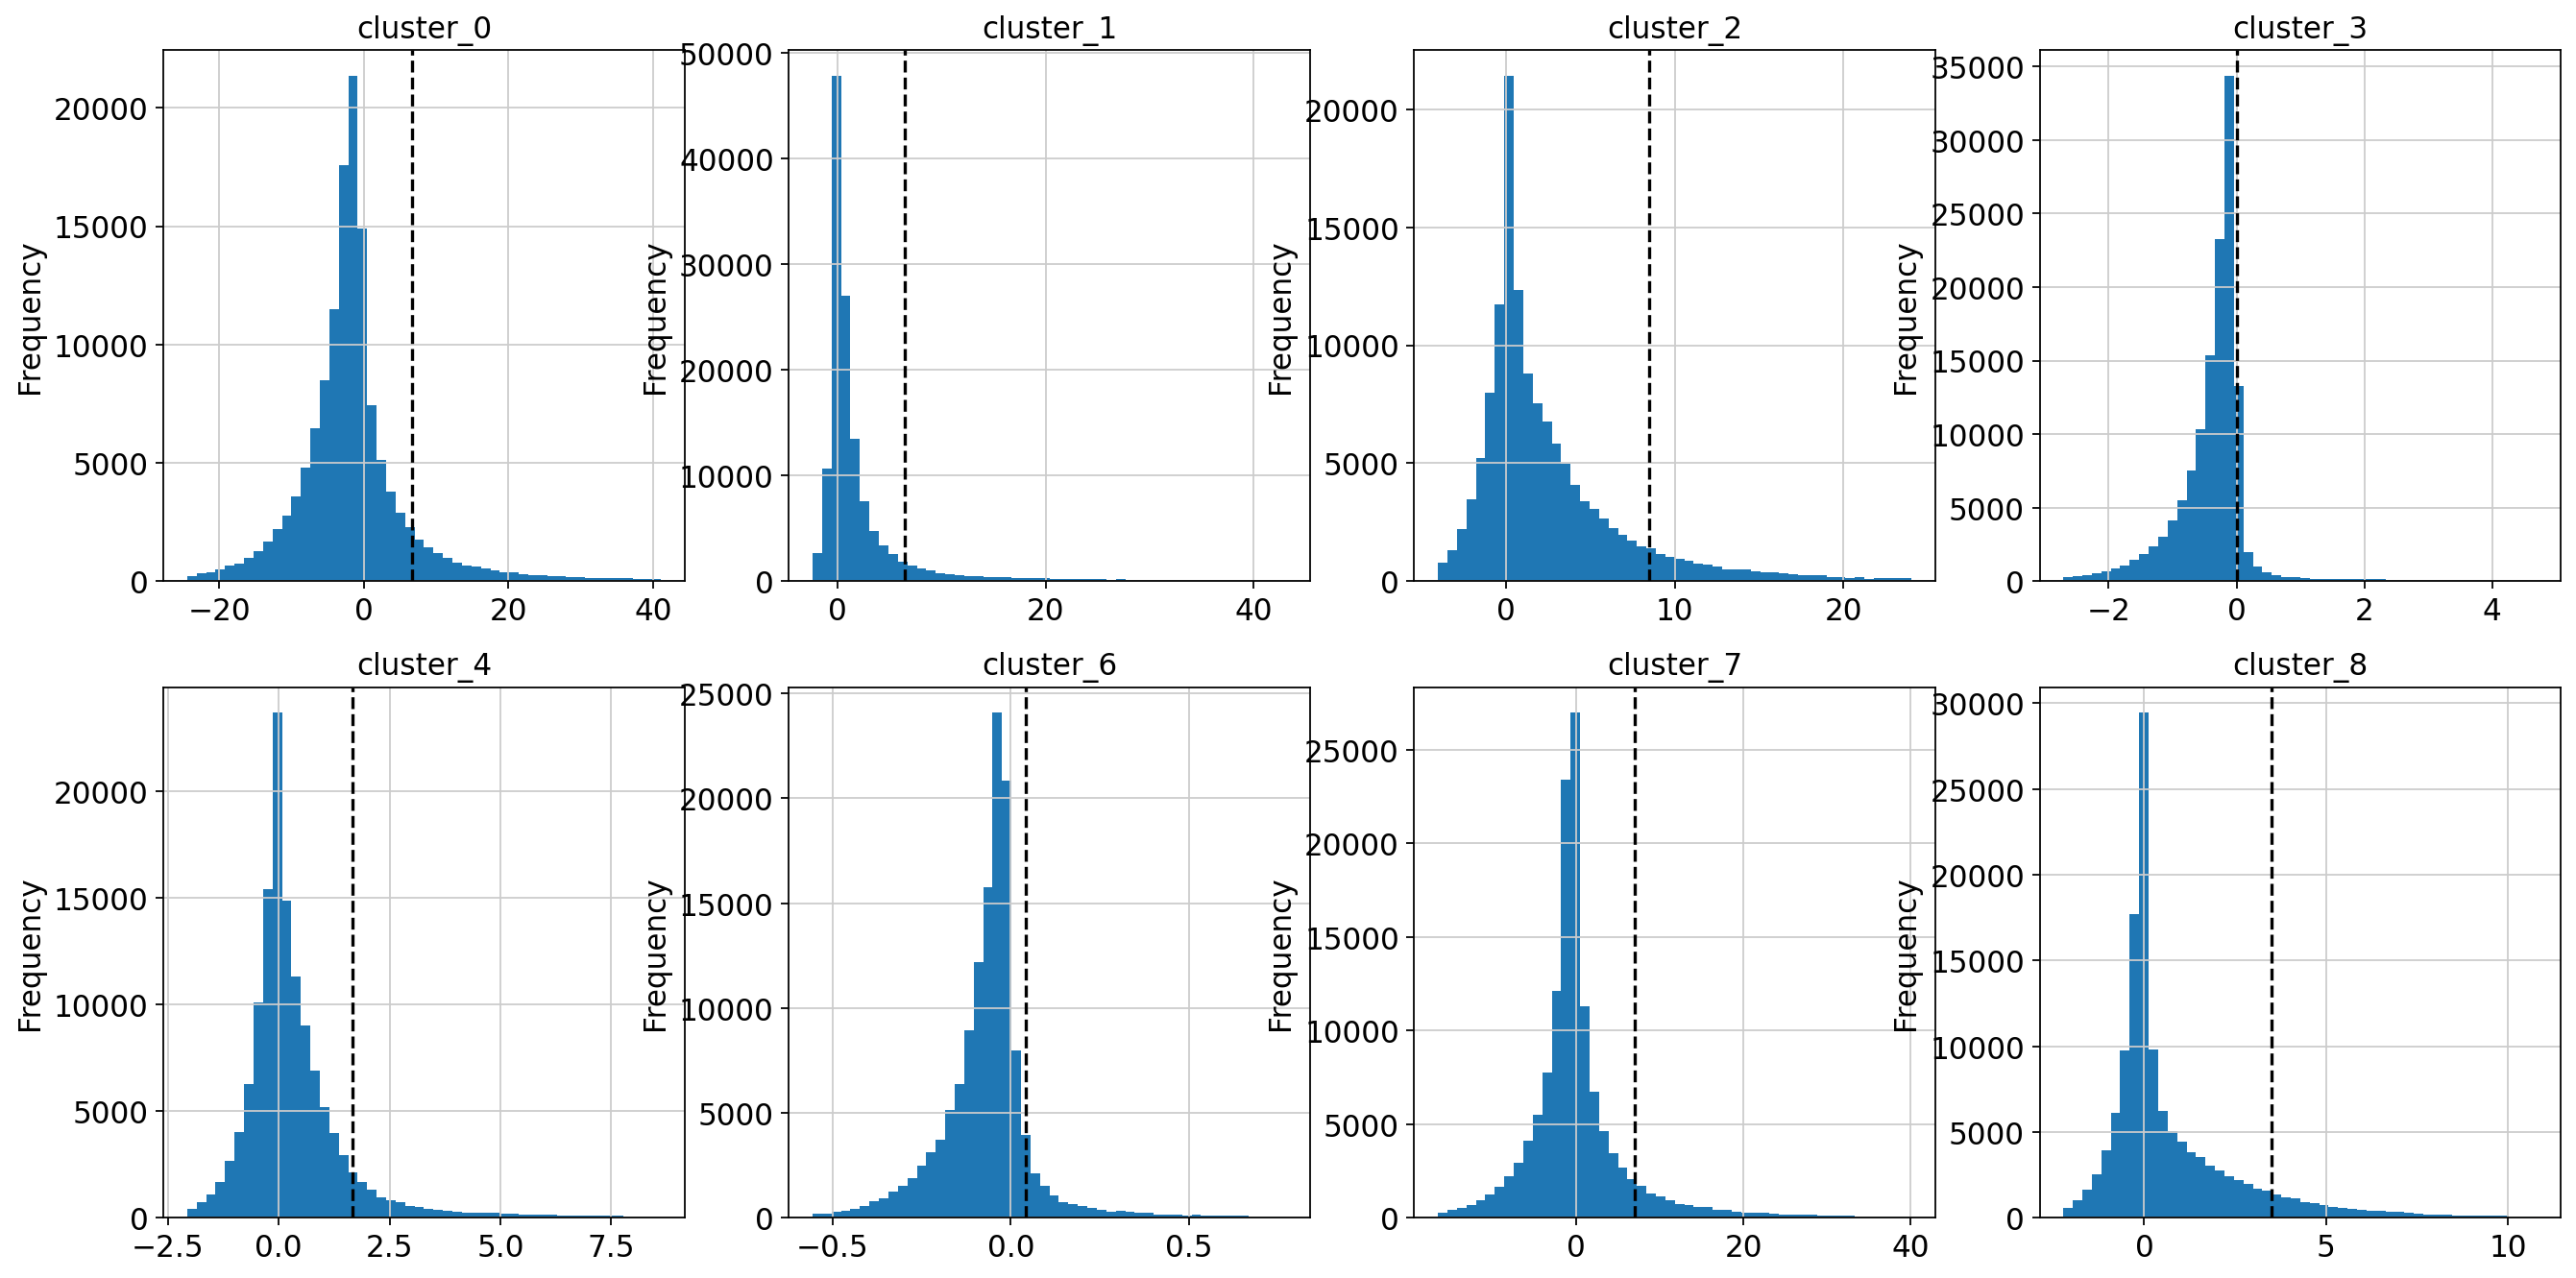

In [166]:
import matplotlib.pyplot as plt

# Define the list of gene modules
gene_modules = list(gene_modules)

# Create a 2 by 4 subplot
fig, axes = plt.subplots(2, 4, figsize=(20,10))

# Iterate over each gene module
for i, c in enumerate(gene_modules):
    # Select the current axis
    ax = axes[i // 4, i % 4]
    
    # Plot the histogram
    dat_df[c].plot.hist(ax=ax, bins=50, range=[dat_df[c].quantile(0.01), dat_df[c].quantile(0.99)],title=c)
    
    # Add the dashed vertical black line
    ax.axvline(x=dat_df[c].quantile(0.9), color='black', linestyle='dashed')

# Show the plot
plt.show()


In [167]:
import pandas as pd

# Compute the 0.8 quantile for each column
quantile_threshold = dat_df.quantile(0.8)

# Create an empty dataframe to store the marked entries
marked_df = pd.DataFrame(index=dat_df.index, columns=dat_df.columns)

# Iterate over each row of the dataframe
for index, row in dat_df.iterrows():
    # Iterate over each column of the dataframe
    for column in dat_df.columns:
        # Mark the entry if it is above the quantile therhold
        if quantile_threshold[column] < 1:
            quantile_threshold[column] = 1
        if row[column] > quantile_threshold[column]:
            marked_df.loc[index, column] = column

marked_df = marked_df[~marked_df.isna().all(axis=1)]
marked_df = (~marked_df.isna()).astype(int)

# Create an empty list to store the columns with value 1
qualified_columns = []

# Iterate over each row in the DataFrame
for _, row in marked_df.iterrows():
    # Get the columns where the cell value is 1
    columns = row[row.eq(1)].index.tolist()

    annot = '_'.join([c.split('_')[1] for c in columns])
    qualified_columns.append(annot)

marked_df['annotation'] = qualified_columns

In [168]:
marked_df['annotation'].value_counts()[:10]

0_7        14316
1           8029
2_8         7221
2_4_8       6297
8           5188
0           4247
1_4         3463
0_1_7       3329
2           3203
1_2_4_8     2791
Name: annotation, dtype: int64

In [81]:
score_data = ad.AnnData(X=np.array(dat_df),obs=adata.obs.drop(columns=list(gene_modules)).copy(),var = pd.DataFrame(index=dat_df.columns))


In [82]:
score_data = score_data[score_data.obs.sample(20000).index]

In [83]:
sc.pp.scale(score_data)
sc.pp.neighbors(score_data, n_neighbors=10)
sc.tl.umap(score_data)


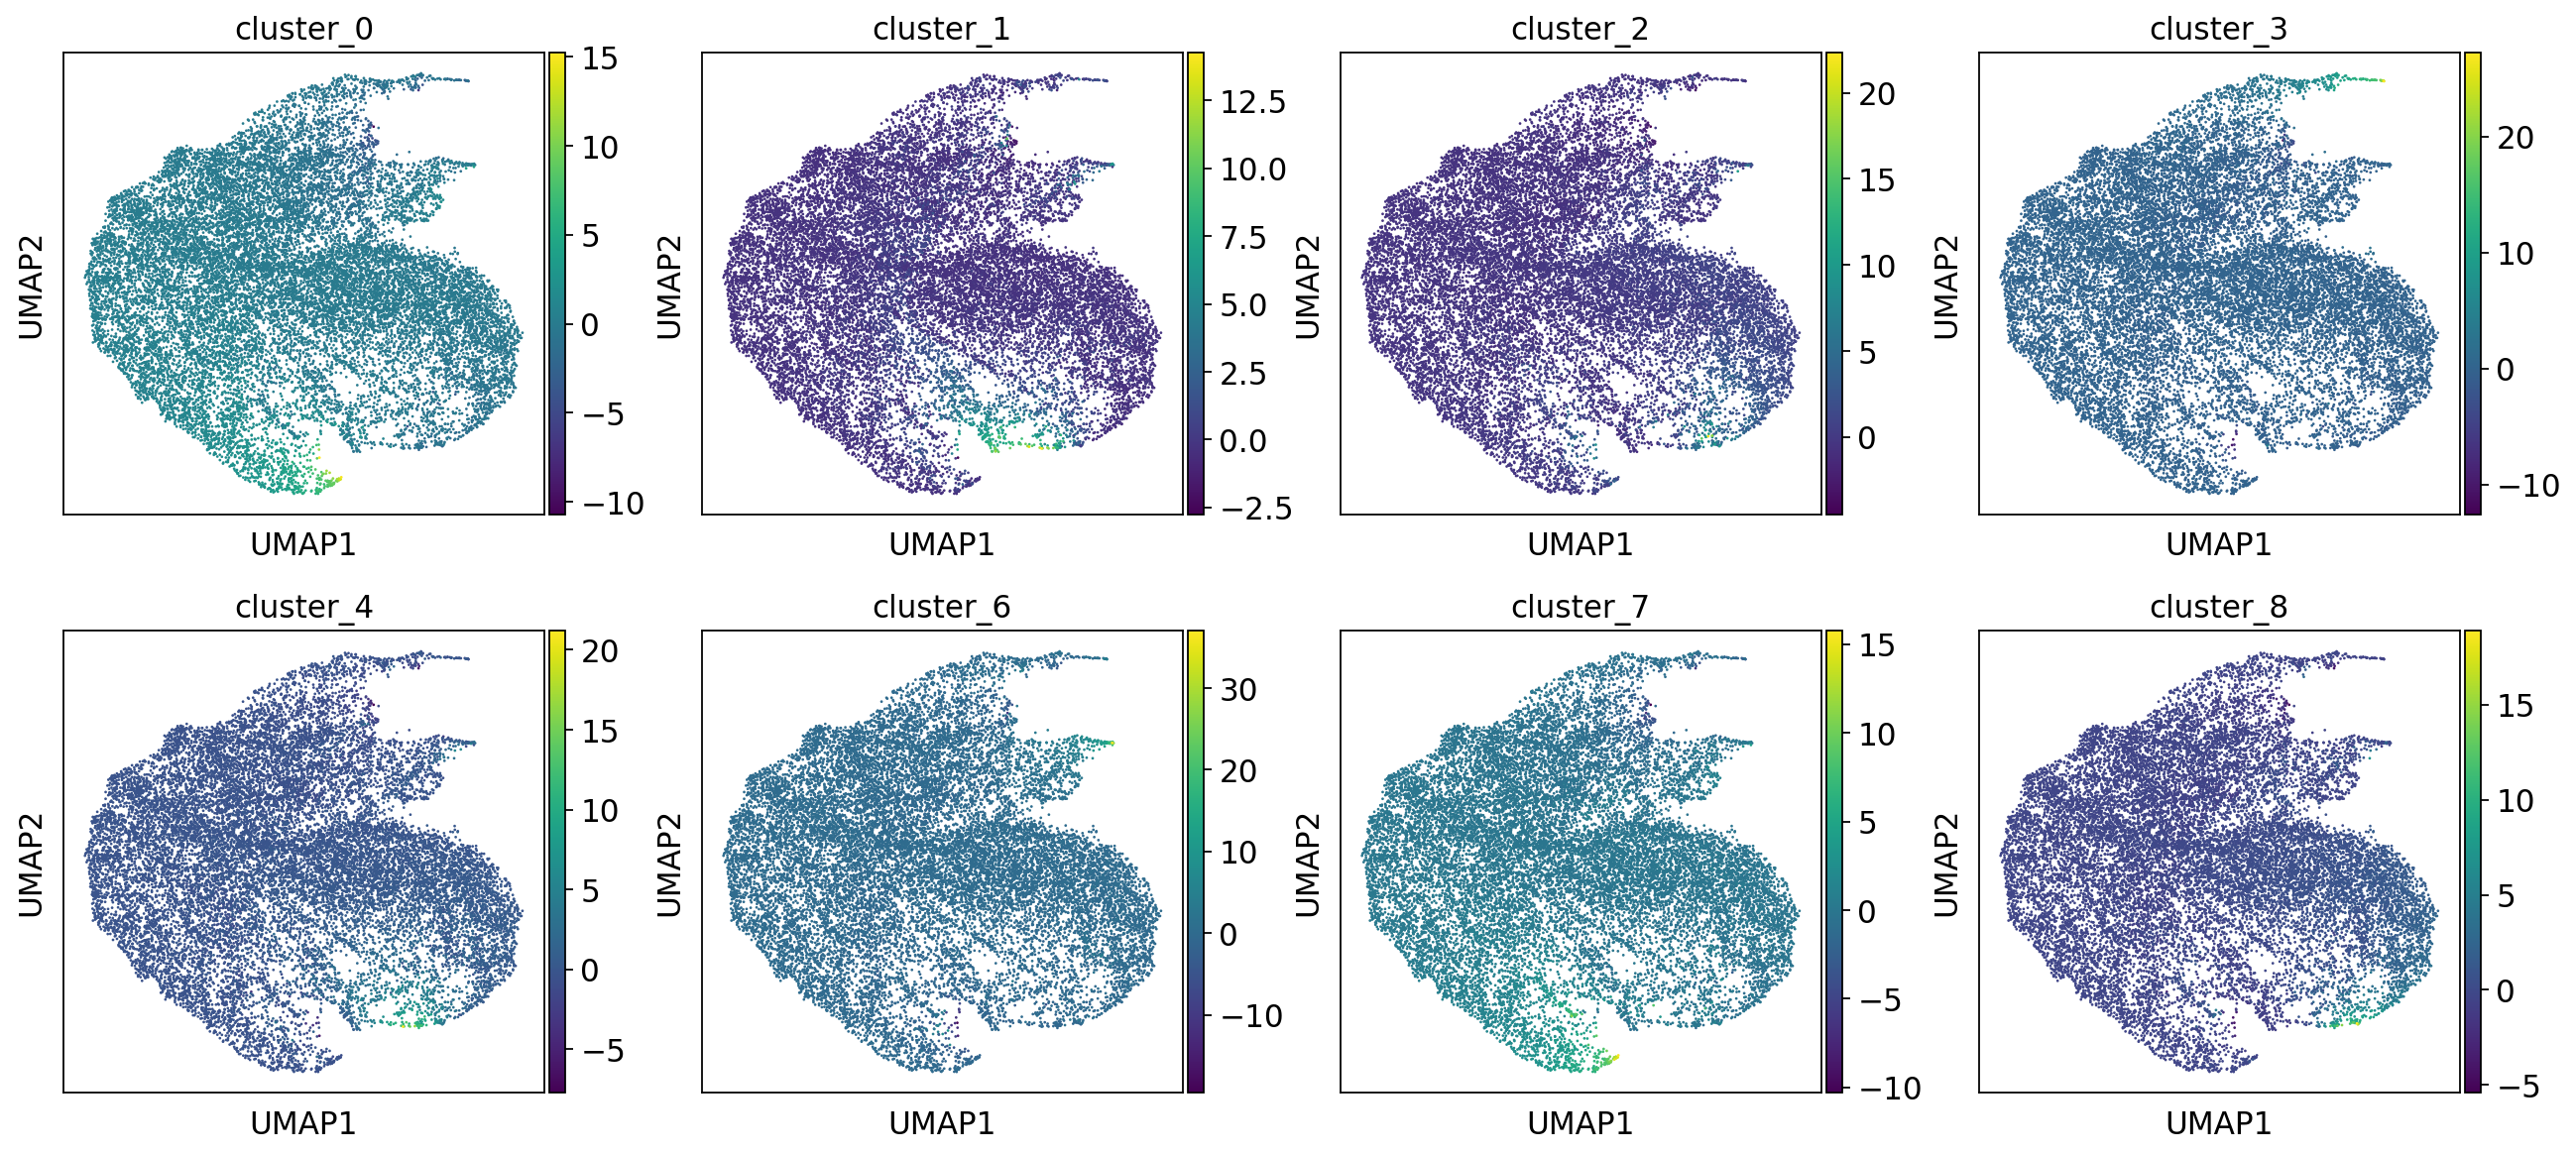

In [84]:
sc.set_figure_params(figsize=(4,4))
sc.pl.umap(score_data, color=list(gene_modules))